# Loading data

In [ ]:
! wget http://files.grouplens.org/datasets/movielens/ml-1m.zip
! unzip ml-1m.zip -d .

In [3]:
import pandas as pd
import numpy as np

In [6]:
ratings = (pd.read_csv('./ml-1m/ratings.dat', engine='python', sep='::', names=['user', 'item', 'rating', 'timestamp'])
    .assign(timestamp=lambda df:pd.to_datetime(df.timestamp * 1000000000))
          )

movies = (pd.read_csv('./ml-1m/movies.dat', engine='python', sep='::', names=['item', 'title', 'genres'])
          .assign(genres=lambda df:df.genres.str.split('|').values)
          .set_index('item', drop=False))

# See http://files.grouplens.org/datasets/movielens/ml-1m-README.txt for more details
users = pd.read_csv('./ml-1m/users.dat', engine='python', sep='::', 
                    names=['user', 'gender', 'age', 'occupation', 'zipcode'])\
    .set_index('user', drop=False)

## Train/test split

 * Ideally time based split
 * For the sake of simplicity, let's just sample ratings uniformly (breaking the time machine rule)

In [3]:
test = ratings.sample(n=100000, random_state=0)
train_ratings_mask = ~ratings.index.isin(test.index)
train = ratings.loc[train_ratings_mask]

test_user_items = test[['user', 'item']]

print(train.shape)
print(test.shape)

test.head()

(900209, 4)
(100000, 4)


,user,item,rating,timestamp
324271,1922,2094,4,2000-11-20 04:34:27
818637,4918,2808,1,2000-07-08 19:29:05
148677,957,1660,4,2000-11-25 05:28:13
778790,4653,914,5,2000-11-29 21:22:43
525489,3245,3324,1,2000-09-07 06:33:31


## Evaluation function

In [4]:
def rmse(predicted_ratings, ground_truth_ratings=test):

    # predicted rating will be nan if no prediction => returning nan as a result if not all test ratings provided
    joined_ratings = pd.merge(
        ground_truth_ratings,
        predicted_ratings, 
        on=['user', 'item'], how='left', suffixes=['_ground_truth', '_predicted'])

    squared_errors = np.power(joined_ratings.rating_ground_truth - joined_ratings.rating_predicted, 2)
    
    return np.sqrt(np.average(squared_errors))

## Matrix factorisation as a neural net

 * See https://github.com/bradleypallen/keras-movielens-cf
 * https://www.quora.com/What-are-some-of-the-better-implementations-of-SVD++

## Factorisation machines
 * https://github.com/scikit-learn-contrib/polylearn/
 * https://github.com/geffy/tffm/
 * https://github.com/jfloff/pywFM
 
## ML-1m benchmarks

http://www.librec.net/example.html

In [24]:
from scipy import sparse

def to_coo(row_indexes, col_indexes, values, shape=None, dtype=np.float64):
    return sparse.coo_matrix((values, (row_indexes, col_indexes)), shape=shape, dtype=dtype)

average_train_rating = train.rating.mean()
train_matrix = to_coo(
    row_indexes=train.user, 
    col_indexes=train.item, 
    values=train.rating - average_train_rating)

train_matrix

<6041x3953 sparse matrix of type '<class 'numpy.float64'>'
	with 900209 stored elements in COOrdinate format>

In [33]:
from sklearn.decomposition import TruncatedSVD

m = TruncatedSVD(n_components=50)
U = m.fit_transform(train_matrix)
V = m.components_.T

print(U.shape)
print(V.shape)


(6041, 50)
(3953, 50)


In [34]:
all_predicted_ratings = average_train_rating + np.dot(U, V.T)
all_predicted_ratings.shape

predicted_ratings = pd.DataFrame.from_dict(
    {'user': test_user_items.user,
     'item': test_user_items.item,
     'rating': all_predicted_ratings[test_user_items.user, test_user_items.item]
    })

print(rmse(predicted_ratings))
predicted_ratings.head()

0.990869577163


,item,rating,user
324271,2094,3.276128,1922
818637,2808,3.141770,4918
148677,1660,3.661736,957
778790,914,3.843276,4653
525489,3324,3.354389,3245


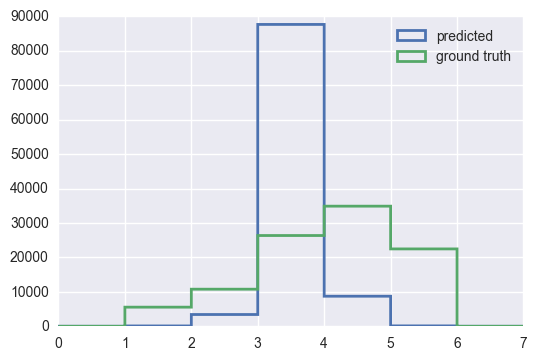

In [36]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

plt.hist(predicted_ratings.rating, bins=np.linspace(0, 7, 8), histtype='step', lw=2, label='predicted');
plt.hist(test.rating, bins=np.linspace(0, 7, 8), histtype='step', lw=2, label='ground truth');
plt.legend();

In [49]:
from keras.layers import Embedding, Reshape, Merge
from keras.models import Sequential
from keras.optimizers import Adamax, RMSprop
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

n_factors = 20
n_users = ratings.user.max() + 1
n_items = ratings.item.max() + 1


In [50]:
from keras.regularizers import l2

class BiasModel(object):
    def __init__(self, n_users=n_users, n_items=n_items, l2_reg=0.00001):
        
        self.model = Sequential()

        self.user_biases = Sequential()
        self.user_biases.add(Embedding(n_users, 1, input_length=1, W_regularizer=l2(l2_reg)))
        self.user_biases.add(Reshape((1,)))

        self.item_biases = Sequential()
        self.item_biases.add(Embedding(n_items, 1, input_length=1, W_regularizer=l2(l2_reg)))
        self.item_biases.add(Reshape((1,)))

        self.model.add(Merge(name='biases', layers=[self.user_biases, self.item_biases], mode='sum'))
        

In [51]:
bias_model = BiasModel()

bias_model.model.compile(loss='mse', optimizer='adamax')

callbacks = [EarlyStopping('val_loss', patience=2)]
history = bias_model.model.fit([train.user.values, train.item.values], train.rating, 
                         nb_epoch=30, validation_split=.1, verbose=2, callbacks=callbacks)


Train on 810188 samples, validate on 90021 samples
Epoch 1/30
14s - loss: 9.5287 - val_loss: 8.4866
Epoch 2/30
14s - loss: 4.3038 - val_loss: 5.7765
Epoch 3/30
14s - loss: 2.5998 - val_loss: 4.6080
Epoch 4/30
16s - loss: 1.9990 - val_loss: 4.0164
Epoch 5/30
16s - loss: 1.7103 - val_loss: 3.6711
Epoch 6/30
16s - loss: 1.5411 - val_loss: 3.4467
Epoch 7/30
16s - loss: 1.4307 - val_loss: 3.2892
Epoch 8/30
16s - loss: 1.3544 - val_loss: 3.1719
Epoch 9/30
16s - loss: 1.2996 - val_loss: 3.0822
Epoch 10/30
16s - loss: 1.2590 - val_loss: 3.0100
Epoch 11/30
16s - loss: 1.2283 - val_loss: 2.9535
Epoch 12/30
17s - loss: 1.2045 - val_loss: 2.9062
Epoch 13/30
17s - loss: 1.1858 - val_loss: 2.8661
Epoch 14/30
16s - loss: 1.1709 - val_loss: 2.8331
Epoch 15/30
16s - loss: 1.1590 - val_loss: 2.8033
Epoch 16/30
16s - loss: 1.1493 - val_loss: 2.7775
Epoch 17/30
17s - loss: 1.1413 - val_loss: 2.7562
Epoch 18/30
17s - loss: 1.1346 - val_loss: 2.7369
Epoch 19/30
17s - loss: 1.1293 - val_loss: 2.7189
Epoch 20

In [62]:
def plot_predicted_distribution(predicted_ratings, ground_truth_ratings=test):
    bins = np.linspace(-.5, 7.5, 9)
    plt.hist(predicted_ratings.rating, 
             bins=bins, normed=True, histtype='step', lw=2, label='predicted')
    plt.hist(ground_truth_ratings.rating, 
             bins=bins, normed=True, histtype='step', lw=2, color='grey', label='ground truth')
    plt.ylabel('rating proportion')
    plt.xlabel('rating value')
    plt.xlim([0, 6]); plt.ylim([0, 1.05])
    plt.xticks(range(1, 6))
    plt.legend(loc=2)

1.05550813973


,item,rating,user
324271,2094,2.957024,1922
818637,2808,2.112133,4918
148677,1660,3.755618,957
778790,914,3.889288,4653
525489,3324,2.064582,3245


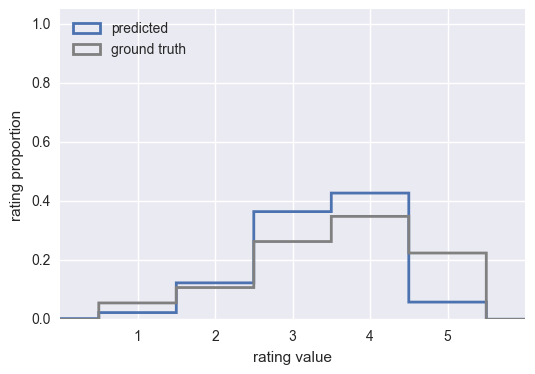

In [63]:
predicted_ratings = pd.DataFrame.from_dict(
    {'user': test_user_items.user,
     'item': test_user_items.item,
     'rating': bias_model.model.predict([test_user_items.user, test_user_items.item]).ravel()
    })

print(rmse(predicted_ratings))

plot_predicted_distribution(predicted_ratings)
predicted_ratings.head()


In [ ]:
n_factors = 20


def create_dot_model(n_users=n_users, n_items=n_items, n_factors=n_factors, l2_reg=0.001):
    user_factors = Sequential()
    user_factors.add(Embedding(n_users, n_factors, input_length=1, W_regularizer=l2(l2_reg)))
    user_factors.add(Reshape((n_factors,)))

    item_factors = Sequential()
    item_factors.add(Embedding(n_items, n_factors, input_length=1, W_regularizer=l2(l2_reg)))
    item_factors.add(Reshape((n_factors,)))

    dot_model = Sequential()
    dot_model.add(Merge([user_factors, item_factors], mode='dot'))
    
    return dot_model

bias_and_product_model = Sequential()
bias_and_product_model.add(Merge(
        layers=create_bias_model().get_layer('biases').layers + [create_dot_model()], 
        mode='sum'))

bias_and_product_model.compile(loss='mse', optimizer='Adamax')


In [ ]:
callbacks = [EarlyStopping('val_loss', patience=2)]
history = bias_and_product_model.fit([train.user.values, train.item.values] * 2, train.rating, 
                         nb_epoch=30, validation_split=.1, verbose=2, callbacks=callbacks)


Train on 810188 samples, validate on 90021 samples
Epoch 1/30


In [77]:
user_biases.get_weights()


[array([[-0.01940012],
        [ 1.6262821 ],
        [ 1.24789929],
        ..., 
        [-0.00703112],
        [ 0.0029576 ],
        [-0.02840925]], dtype=float32)]

In [53]:
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

callbacks = [EarlyStopping('val_loss', patience=2)]
history = model.fit([train.user.values, train.item.values], train.rating, nb_epoch=30, validation_split=.1, verbose=2, callbacks=callbacks)

Train on 810188 samples, validate on 90021 samples
Epoch 1/30
114s - loss: 11.3335 - val_loss: 14.2454
Epoch 2/30
125s - loss: 3.4636 - val_loss: 14.2305
Epoch 3/30
124s - loss: 1.7406 - val_loss: 14.2307
Epoch 4/30
122s - loss: 1.2695 - val_loss: 14.2310
Epoch 5/30
119s - loss: 1.0766 - val_loss: 14.2310
